# Демодуляция. 
# Часть 3. Double Sideband Transmitted Carrier 
# (AM-DSB-TC)

## 1. Некогерентная демодуляция с помощью детектора огибающей

Рассмотрим некогерентный способ приема АМ-сигналов. Его преимуществом является простота, так как в этом случае не требуется восстанавливать несущую с точностью до фазы. Пусть при формировании АМ-сигнала выполняется условие:

$$A_с \ge m_{\max },$$

где $A_с$- амплитуда несущей, а $m_{\max }$ - максимальное значение информационного сообщения. Тогда все сведения о сообщении содержатся в огибающей АМ-сигнала. Таким образом, некогерентный приемник представляет из себя просто детектор огибающей. Чтобы выделить огибающую, можно использовать нелинейное преобразование, а затем убрать лишние компоненты с помощью низкочастотного фильтра. В качестве нелинейного преобразования, например, можно взять вычисление абсолютного значения. Схема приемника при этом будет иметь вид:

<img src="../../images/DSB_TC_Receiver_3_1.png" width=500/>

Рассмотрим, как работу такого приемника можо описать в аналитическим виде. Вычисление абсолютного значания приводит к тому, что участки сигнала, на которых он принимает отрицательные значания, изменяют свой знак на противоположный. Для простоты рассмотрим случай чисто гармонического сигнала. Операция взятия модуля  эквивалентна умножению на последовательность прямоугольных импульсов, значения которых равны 1, когда гармонический сигнал больше нуля, и равны -1, когда сигнал меньше нуля. Таким образом, прямоугольные импульсы на половине периода сигнала принимают значения, равные 1, а на другой половине -1. Период прямоугольных импульсов совпадает с периодом гармонического сигнала. 

Пусть гармонический сигнал имеет вид:

$$s_{\;\textrm{in}} =\textrm{Acos}\left(\omega_c t\right),$$

где $\omega_c$ - циклическая частота в рад/с. Сигнал из прямоугольных импульсов имеет тот же период, поэтому его можно разложить в ряд Фурье:

$$s_{\textrm{rect}} =A_0 +A_1 \cos \left(\omega_c t\right)+A_2 \cos \left(2\omega_c t\right)+A_3 \cos \left(3\omega_c t\right)+\cdots$$

Произведение АМ-сигнала и $s_{\textrm{rect}}$ эквивалентно умножению АМ-сигнала на сумму ряда. В этом ряду есть слагаемое $A_1 \cos \left(\omega_c t\right)$, которое соответствует тону, частота которого совпадающает с частотой несущей. Остальные слагаемые ряда будет переносить информационный сигнал на другие частоты, кратные частоте несущей. Все побочные слагаемые в дальнейшем можно удалить с помощью фильтра нижних частот.

Ниже представлен скрипт, выполняющий некогерентный прием сигнала с амплитудной модуляцией. 

<IPython.core.display.Javascript object>


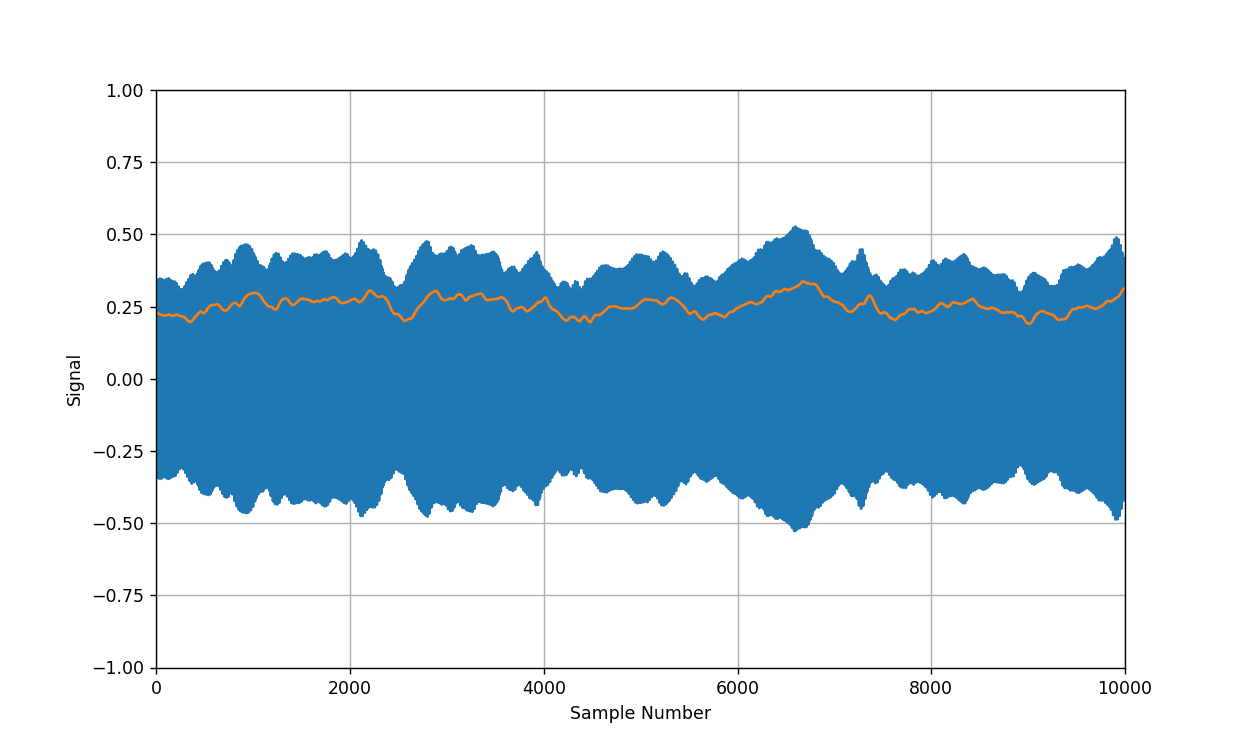

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import resample_poly, firls, lfilter

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей
freq_offset = 1000         # расстройка по частоте (Hz)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_TC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# получение коэффициентов ФНЧ
H = firls(175, (0, 20e3, 30e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Signal')
ax.set_xlim(0, signal_frame_size)
ax.set_ylim(-1, 1)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []
FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                          # выделяем один канал и нормируем отсчеты к единице
    
    # вычисление модуля сигнала для амплитудной детекции
    abs_signal = np.abs(am_signal)
    
    # фильтрация сигнала
    baseband_signal, FIR_tap_values = lfilter(H, 1.0, abs_signal, zi=FIR_tap_values)
    
    # построение временных диаграмм
    ax.lines[0].set_ydata(am_signal)
    ax.lines[1].set_ydata(baseband_signal)
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = baseband_signal - baseband_signal.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены временные диаграммы сигналов на входе (синий) и выходе (оранжевый) демодулятора. Можно увидеть, что сигнал на выходе совпадает с огибающей АМ-сигнала. 

На слух можно сделать вывод, что аудиосообщение восстанавливается без явных искажений.

## 2. Некогерентная демодуляция при квадратурном приеме

Рассмотрим как изменится структура некогерентного демодулятора в случае квадратурного приема. Сигнал теперь комплексный с односторонним спектром. Отличае от случая действительнго сигнала заключается в том, что теперь АМ-сигнал имеет вид:

$$s_{\textrm{am}} ={A\left(t\right)\cdot e}^{j\cdot \omega_с t}.$$ 

Если при формировании сигнала выполнено условие $A_с \ge m_{\max }$, то информационное сообщение можно восстановить из огибающей сигнала. Чтобы найти огибающую комплексного сигнала, достаточно вычислить его модуль. Схема приемника очень простая и представлена ниже:

<img src="../../images/DSB_TC_Receiver_3_2.png" width=500/>

Ниже представлен скрипт, выполняющий некогерентный прием сигнала с амплитудной модуляцией. 

<IPython.core.display.Javascript object>


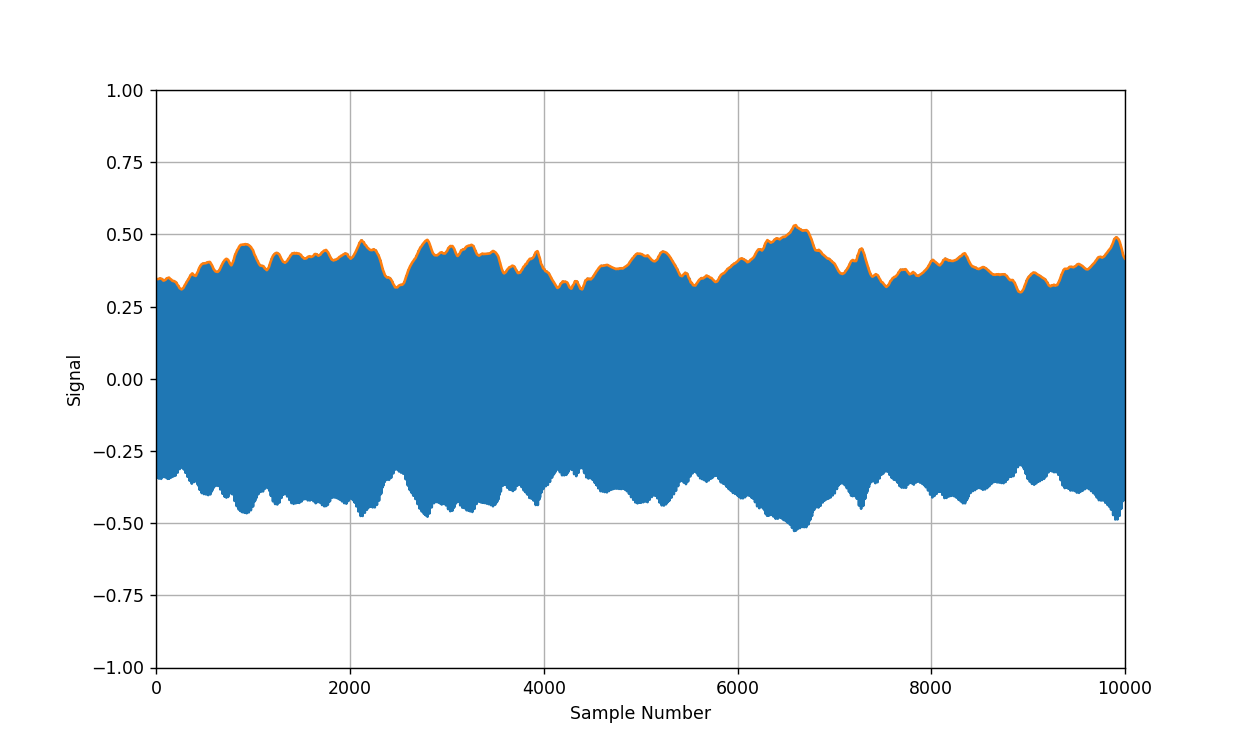

In [2]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей

freq_offset = 1000               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_TC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Signal')
ax.set_xlim(0, signal_frame_size)
ax.set_ylim(-1, 1)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = (am_signal[:,0] + 1j*am_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
    # вычисление модуля сигнала для амплитудной детекции
    baseband_signal = np.abs(am_signal)
    
    # построение временных диаграмм
    ax.lines[0].set_ydata(np.real(am_signal))
    ax.lines[1].set_ydata(baseband_signal)
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = baseband_signal - baseband_signal.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены временные диаграммы сигналов на входе (синий, действительная составляющая) и выходе (оранжевый) демодулятора. Можно увидеть, что сигнал на выходе фильтра совпадает с огибающей АМ-сигнала. 

На слух можно сделать вывод, что аудиосообщение восстанавливается без явных искажений.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR